# Part 2, Topic 1: CPA Attack on 32bit AES (MAIN)

---
NOTE: This lab references some (commercial) training material on [ChipWhisperer.io](https://www.ChipWhisperer.io). You can freely execute and use the lab per the open-source license (including using it in your own courses if you distribute similarly), but you must maintain notice about this source location. Consider joining our training course to enjoy the full experience.

---

**SUMMARY:** *So far, we've been focusing on a single implementation of AES, TINYAES128C (or AVRCRYPTOLIB, if you're on XMEGA). TINYAES128C, which is designed to run on a variety of microcontrollers, doesn't make any implementation specific optimizations. In this lab, we'll look at how we can break a 32-bit optimized version of AES using a CPA attack.*

**LEARNING OUTCOMES:**

* Understanding how AES can be optimized on 32-bit platforms.
* Attacking an optimized version of AES using CPA

## Optimizing AES

A 32-bit machine can operate on 32-bit words, so it seems wasteful to use the same 8-bit operations. For example, if we look at the SBox operation:

$$
b = sbox(state) = sbox(\left[ \begin{array}
& S0 & S4 & S8 & S12 \\
S1 & S5 & S9 & S13 \\
S2 & S6 & S10 & S14 \\
S3 & S7 & S11 & S15
\end{array} \right]) = \left[ \begin{array}
& S0 & S4 & S8 & S12 \\
S5 & S9 & S13 & S1 \\
S10 & S14 & S2 & S6 \\
S15 & S3 & S7 & S11
\end{array} \right]
$$

we could consider each row as a 32-bit number and do three bitwise rotates instead of moving a bunch of stuff around in memory. Even better, we can speed up AES considerably by generating 32-bit lookup tables, called T-Tables, as was described in the book [The Design of Rijndael](http://www.springer.com/gp/book/9783540425809) which was published by the authors of AES.

In order to take full advantage of our 32 bit machine, we can examine a typical round of AES. With the exception of the final round, each round looks like:

$\text{a = Round Input}$

$\text{b = SubBytes(a)}$

$\text{c = ShiftRows(b)}$

$\text{d = MixColumns(c)}$

$\text{a' = AddRoundKey(d) = Round Output}$

We'll leave AddRoundKey the way it is. The other operations are:

$b_{i,j} = \text{sbox}[a_{i,j}]$

$\left[ \begin{array} { c } { c _ { 0 , j } } \\ { c _ { 1 , j } } \\ { c _ { 2 , j } } \\ { c _ { 3 , j } } \end{array} \right] = \left[ \begin{array} { l } { b _ { 0 , j + 0 } } \\ { b _ { 1 , j + 1 } } \\ { b _ { 2 , j + 2 } } \\ { b _ { 3 , j + 3 } } \end{array} \right]$

$\left[ \begin{array} { l } { d _ { 0 , j } } \\ { d _ { 1 , j } } \\ { d _ { 2 , j } } \\ { d _ { 3 , j } } \end{array} \right] = \left[ \begin{array} { l l l l } { 02 } & { 03 } & { 01 } & { 01 } \\ { 01 } & { 02 } & { 03 } & { 01 } \\ { 01 } & { 01 } & { 02 } & { 03 } \\ { 03 } & { 01 } & { 01 } & { 02 } \end{array} \right] \times \left[ \begin{array} { c } { c _ { 0 , j } } \\ { c _ { 1 , j } } \\ { c _ { 2 , j } } \\ { c _ { 3 , j } } \end{array} \right]$

Note that the ShiftRows operation $b_{i, j+c}$ is a cyclic shift and the matrix multiplcation in MixColumns denotes the xtime operation in GF($2^8$).

It's possible to combine all three of these operations into a single line. We can write 4 bytes of $d$ as the linear combination of four different 4 byte vectors:

$\left[ \begin{array} { l } { d _ { 0 , j } } \\ { d _ { 1 , j } } \\ { d _ { 2 , j } } \\ { d _ { 3 , j } } \end{array} \right] = \left[ \begin{array} { l } { 02 } \\ { 01 } \\ { 01 } \\ { 03 } \end{array} \right] \operatorname { sbox } \left[ a _ { 0 , j + 0 } \right] \oplus \left[ \begin{array} { l } { 03 } \\ { 02 } \\ { 01 } \\ { 01 } \end{array} \right] \operatorname { sbox } \left[ a _ { 1 , j + 1 } \right] \oplus \left[ \begin{array} { c } { 01 } \\ { 03 } \\ { 02 } \\ { 01 } \end{array} \right] \operatorname { sbox } \left[ a _ { 2 , j + 2 } \right] \oplus \left[ \begin{array} { c } { 01 } \\ { 01 } \\ { 03 } \\ { 02 } \end{array} \right] \operatorname { sbox } \left[ a _ { 3 , j + 3 } \right]$

Now, for each of these four components, we can tabulate the outputs for every possible 8-bit input:

$T _ { 0 } [ a ] = \left[ \begin{array} { l l } { 02 \times \operatorname { sbox } [ a ] } \\ { 01 \times \operatorname { sbox } [ a ] } \\ { 01 \times \operatorname { sbox } [ a ] } \\ { 03 \times \operatorname { sbox } [ a ] } \end{array} \right]$

$T _ { 1 } [ a ] = \left[ \begin{array} { l } { 03 \times \operatorname { sbox } [ a ] } \\ { 02 \times \operatorname { sbox } [ a ] } \\ { 01 \times \operatorname { sbox } [ a ] } \\ { 01 \times \operatorname { sbox } [ a ] } \end{array} \right]$

$T _ { 2 } [ a ] = \left[ \begin{array} { l l } { 01 \times \operatorname { sbox } [ a ] } \\ { 03 \times \operatorname { sbox } [ a ] } \\ { 02 \times \operatorname { sbox } [ a ] } \\ { 01 \times \operatorname { sbox } [ a ] } \end{array} \right]$

$T _ { 3 } [ a ] = \left[ \begin{array} { l l } { 01 \times \operatorname { sbox } [ a ] } \\ { 01 \times \operatorname { sbox } [ a ] } \\ { 03 \times \operatorname { sbox } [ a ] } \\ { 02 \times \operatorname { sbox } [ a ] } \end{array} \right]$

These tables have 2^8 different 32-bit entries, so together the tables take up 4 kB. Finally, we can quickly compute one round of AES by calculating

$\left[ \begin{array} { l } { d _ { 0 , j } } \\ { d _ { 1 , j } } \\ { d _ { 2 , j } } \\ { d _ { 3 , j } } \end{array} \right] = T _ { 0 } \left[ a _ { 0 } , j + 0 \right] \oplus T _ { 1 } \left[ a _ { 1 } , j + 1 \right] \oplus T _ { 2 } \left[ a _ { 2 } , j + 2 \right] \oplus T _ { 3 } \left[ a _ { 3 } , j + 3 \right]$

All together, with AddRoundKey at the end, a single round now takes 16 table lookups and 16 32-bit XOR operations. This arrangement is much more efficient than the traditional 8-bit implementation. There are a few more tradeoffs that can be made: for instance, the tables only differ by 8-bit shifts, so it's also possible to store only 1 kB of lookup tables at the expense of a few rotate operations.

While the TINYAES128C library we've been using doesn't make this optimization, another library included with ChipWhisperer called MBEDTLS does.

In [16]:
PLATFORM="CWLITEARM"
CRYPTO_TARGET="MBEDTLS"

In [17]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET"
cd ../../../hardware/victims/firmware/simpleserial-aes
make PLATFORM=$1 CRYPTO_TARGET=$2

Building for platform CWLITEARM with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_1_1
Blank crypto options, building for AES128
rm -f -- simpleserial-aes-CWLITEARM.hex
rm -f -- simpleserial-aes-CWLITEARM.eep
rm -f -- simpleserial-aes-CWLITEARM.cof
rm -f -- simpleserial-aes-CWLITEARM.elf
rm -f -- simpleserial-aes-CWLITEARM.map
rm -f -- simpleserial-aes-CWLITEARM.sym
rm -f -- simpleserial-aes-CWLITEARM.lss
rm -f -- objdir/*.o
rm -f -- objdir/*.lst
rm -f -- simpleserial-aes.s simpleserial.s stm32f3_hal.s stm32f3_hal_lowlevel.s stm32f3_sysmem.s aes.s aes-independant.s
rm -f -- simpleserial-aes.d simpleserial.d stm32f3_hal.d stm32f3_hal_lowlevel.d stm32f3_sysmem.d aes.d aes-independant.d
rm -f -- simpleserial-aes.i simpleserial.i stm32f3_hal.i stm32f3_hal_lowlevel.i stm32f3_sysmem.i aes.i aes-independant.i
.
Welcome to another exciting ChipWhisperer target build!!
arm-none-eabi-gcc.exe (GNU Tools for ARM Embedded Processors 6-2017-q1-update) 6.3.1 20170215 (release) [ARM/embedded-6-branch

In [5]:
%run "../../Helper_Scripts/Setup_Generic.ipynb"

Serial baud rate = 38400
INFO: Found ChipWhisperer😍


In [18]:
fw_path = '../../../hardware/victims/firmware/simpleserial-aes/simpleserial-aes-{}.hex'.format(PLATFORM)
cw.program_target(scope, prog, fw_path)

Serial baud rate = 115200
Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 5971 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 5971 bytes
Serial baud rate = 38400


In [19]:
#Capture Traces
from tqdm import tnrange, trange
import numpy as np
import time

ktp = cw.ktp.Basic()

traces = []
N = 100  # Number of traces
project = cw.create_project("32bit_AES.cwp", overwrite=True)

for i in trange(N, desc='Capturing traces'):
    key, text = ktp.next()  # manual creation of a key, text pair can be substituted here

    trace = cw.capture_trace(scope, target, text, key)
    if trace is None:
        continue
    project.traces.append(trace)

print(scope.adc.trig_count)

Capturing traces: 100%|██████████████████████| 100/100 [00:02<00:00, 40.30it/s]

28844


If we plot the AES power trace:

<IPython.core.display.Javascript object>


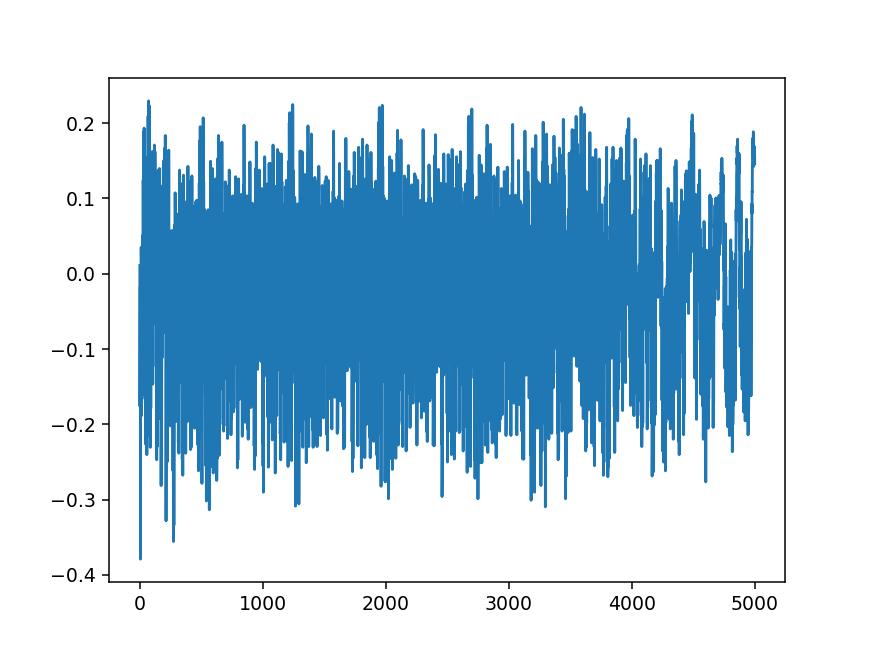

In [8]:
%matplotlib notebook
import matplotlib.pyplot as plt

plt.figure()
plt.plot(project.waves[0])
plt.show()

You probably can't even pick out the different AES rounds anymore (whereas it was pretty obvious on TINYAES128C). MBED is also way faster - we only got part way into round 2 with 5000 samples of TINYAES, but with MBED we can finish the entire encryption in less than 5000 samples! Two questions we need to answer now are:

1. Is it possible for us to break this AES implementation?
1. If so, what sort of leakage model do we need?

As it turns out, the answers are:

1. Yes!
1. We can continue to use the same leakage model - the SBox output

This might come as a surprise, but it's true! Shift rows is just moving things around, so it doesn't really change anything about our attack, and MixColumns is linear, so it also doesn't affect our attack. Try the analysis for yourself now and verify that this is correct: